# Correlation and Convolution
Convolution is a filtering operation that expresses the amount of overlap of one function as it is shifted over another function.
$$f \otimes h = \sum_k\sum_l f(k, l)h(k, l)$$

Correlation compares the similarity of two sets of data
$$f * h = \sum_k\sum_l f(k, l)h(-k, -l)$$

# Gaussian
### Gaussian Filter
Used for blurring images
- 1D: $g(x)=e^\frac{-x^2}{2\sigma ^2}$
- 2D: $g(x, y)=e^\frac{-(x^2 + y^2)}{2\sigma ^2}$

### Laplacian of Gaussian
Detects edges through zero crossings
- 1D: $LoG(x)=-\frac{1}{\pi\sigma ^4}\Big[ 1-\frac{x^2}{2\sigma ^2}\Big]e^\frac{-x^2}{2\sigma ^2}$
- 2D: $LoG(x, y)=-\frac{1}{\pi\sigma ^4}\Big[ 1-\frac{x^2 + y^2}{2\sigma ^2}\Big]e^\frac{-(x^2 + y^2)}{2\sigma ^2}$

In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as cvF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
toTensor = transforms.ToTensor()
toImage = transforms.ToPILImage()
toGrayscale = transforms.Grayscale()

image = Image.open("img1.png")
image_tensor = toGrayscale(toTensor(image)[0:3]).to(device)

Blurring image with gaussian filter

In [3]:
kernel_size = 5
sigma = 1

# Get x and y
ax = torch.arange(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0, device=device, dtype=torch.float)
xx, yy = torch.meshgrid(ax, ax, indexing=None)

# Build gaussian kernel using formula
gaussian_kernel = torch.exp(-0.5 * (xx ** 2 + yy ** 2) / sigma ** 2)
gaussian_kernel /= gaussian_kernel.sum()

gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
blurred_image_tensor = F.conv2d(image_tensor, gaussian_kernel, padding=kernel_size // 2)

blurred_image = toImage(blurred_image_tensor)

/Users/davidrobinson/Documents/GitHub/LearningPortfolio/.venv/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Adding noise to image

In [4]:
noise = torch.randn(image_tensor.size(), device=device) / 10
noisy_image_tensor = image_tensor + noise
noisy_image_tensor = torch.clamp(noisy_image_tensor, 0, 1)

noisy_image = toImage(noisy_image_tensor)

Applying Laplacian of Gaussian for edge detection

In [5]:
kernel_size = 5
sigma = 1

a = torch.arange(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0, device=device, dtype=torch.float)
xx, yy = torch.meshgrid(a, a, indexing=None)

log_kernel = -1 / (torch.pi * sigma ** 4) * (1 - (xx**2 + yy**2) / (2 * sigma**2)) * torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
log_kernel -= log_kernel.mean()
log_kernel = log_kernel.view(1, 1, kernel_size, kernel_size)
log_image_tensor = F.conv2d(image_tensor, log_kernel, padding=kernel_size // 2)
log_image = toImage(log_image_tensor)

Approximating Laplacian of Gaussian with Difference of Gaussian

In [6]:
blur1 = cvF.gaussian_blur(image_tensor, 5, 1)
blur2 = cvF.gaussian_blur(image_tensor, 5, 2)
dog_image_tensor = blur1 - blur2
dog_image = toImage(dog_image_tensor)

### Display images

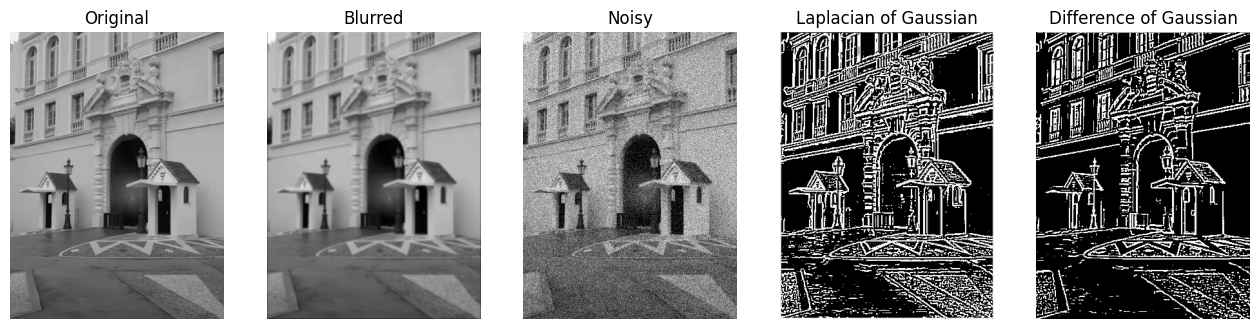

In [7]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 5, 1)
plt.imshow(image, 'gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 5, 2)
plt.imshow(blurred_image, 'gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 5, 3)
plt.imshow(noisy_image, 'gray')
plt.axis('off')
plt.title('Noisy')

plt.subplot(1, 5, 4)
plt.imshow(log_image, 'gray')
plt.axis('off')
plt.title('Laplacian of Gaussian')

plt.subplot(1, 5, 5)
plt.imshow(dog_image, 'gray')
plt.axis('off')
plt.title('Difference of Gaussian')

plt.show()